In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
dataf = pd.read_csv("results/responses.csv")

(0.0, 250.0)

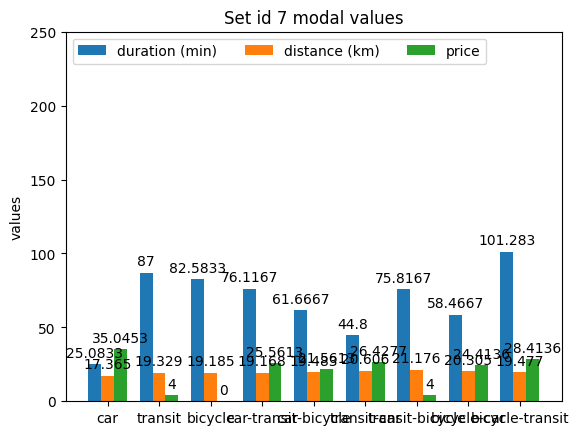

In [21]:
setid_7 = dataf.loc[dataf['setID'] == 7]


values = {"duration (min)": [i/60 for i in setid_7['duration'].to_list()],
          "distance (km)": [i/1000 for i in setid_7['distance'].to_list()],
          "price": setid_7['price'].to_list()}

modal = setid_7['modal'].to_list()


fig, ax = plt.subplots()

x = np.arange(len(modal))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

for attribute, measurement in values.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('values')
ax.set_title('Set id 7 modal values')
ax.set_xticks(x + width, modal)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 250)